In [1]:
# import Pkg; Pkg.add("DataFrames")
using KrylovKit
include("ed.jl")

main (generic function with 1 method)

In [133]:
function Hamiltonian_DVR(state; Nsites, mmax, g, angle, Estrength, pairs)
    dim = Int(2*mmax + 1)
    final_state = zeros(ComplexF64, size(state))
    for i in 1:Nsites
        # Ti
        for k in 1:dim^Nsites # iterate over all states
            mk = ((k-1)%dim^i) ÷ dim^(i-1) # m value at atom from 0 to dim-1
            φi = mk/dim*2π
            
            # diagonal
            final_state[k] += state[k]*((-cos(angle)*cos(φi) - sin(angle)*sin(φi)) * Estrength + mmax*(mmax+1)/3)
            
            for l in 0:dim-1
                if l == mk
                    continue
                end
                final_state[k] += (-1)^(mk - l) * cos(π*(mk - l)/dim)/(2*sin(π*(mk - l)/dim)^2)*state[k + (l - mk)*dim^(i-1)]
            end
        end
        # Vij
        if g == 0
            continue
        end

        site_pairing = (pairs == "nearest") ? min(i+1, Nsites) : Nsites
        for j in (i+1):site_pairing
            c = g/abs(j-i)^3
            for k in 1:dim^Nsites
                mk_i = ((k-1)%dim^i) ÷ dim^(i-1)
                φi = mk_i/dim*2π
                mk_j = ((k-1)%dim^j) ÷ dim^(j-1)
                φj = mk_j/dim*2π
                
                final_state[k] += c*(sin(φi)*sin(φj) - 2* cos(φi)*cos(φj))*state[k]
            end
        end
    end
    return final_state
end

mmax = 1.5
Nsites = 2
angle = 0
Estrength = 0
g = 0.001
pairs = "nearest"
energies = 20

initial_state = rand(ComplexF64, Int(2*mmax+1)^Nsites)
H(x) = Hamiltonian_DVR(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs)
memory = @allocated(tmp = KrylovKit.eigsolve(H, initial_state, energies, :SR))
vals, vecs, info = tmp

vals

┌ Warning: Invariant subspace of dimension 13 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 20`); setting `howmany = 13`.
└ @ KrylovKit C:\Users\jonat\.julia\packages\KrylovKit\wPepJ\src\eigsolve\arnoldi.jl:200


13-element Vector{ComplexF64}:
  0.4992497968281175 + 5.1693095850823013e-17im
 0.49974942173444076 - 4.3915177401501175e-17im
  0.5002494220156903 + 9.485295881597606e-17im
  0.5007497969218673 - 4.3802467874467135e-17im
   2.498500000093752 + 1.508703919733292e-16im
   2.499500000281253 + 1.6761942379209848e-17im
  2.4999999999999987 - 9.908401375589536e-18im
    2.50049999971875 - 2.027223674215233e-16im
    2.50149999990625 - 4.3457464283222624e-17im
   4.499250203078133 + 1.2489083223731858e-16im
   4.499750577984308 + 5.901623855169933e-17im
   4.500250578265564 - 1.9719459064621924e-16im
    4.50075020317188 + 4.817538722977961e-18im

In [136]:
function inversion_projection_dvr(state; Nsites, mmax, parity="even", direction="updown")
    # LR: phi -> phi + pi
    # updown: phi -> -phi

    dim = Int(2*mmax + 1)
    projected_state = zero(state)

    for index in 0:length(state)-1
        if direction == "updown"
            inverted_index = sum([((dim - (index÷dim^k)%dim)%dim)*dim^k for k in 0:Nsites-1])
        else
            if dim%2 != 0
                throw(ArgumentError(string("2*mmax + 1 must be even for left-right symmetry. 2*mmax+1=", dim)))
            end
            half_dim = dim ÷ 2
            # inverted_index = sum([((half_dim + (index÷dim^k)%dim)%dim)*dim^k for k in 0:Nsites-1])
            # println((index÷dim^1)%dim, " " , (half_dim - (index÷dim^1)%dim + dim*((index÷dim^1)%dim > half_dim)))
            inverted_index = sum([(half_dim - (index÷dim^k)%dim + dim*((index÷dim^k)%dim > half_dim))*dim^k for k in 0:Nsites-1])
        end
        
        projection_helper(state, projected_state, index, inverted_index, parity)
    end

    return projected_state
end
println(sum(abs.(vecs[1]).^2))
sum(abs.(inversion_projection_dvr(vecs[1]; Nsites, mmax, parity="even", direction="LR")).^2)

1.0000000000000007


0.49987490622755104

In [ ]:
tmp = zeros(ComplexF64, Int(2*mmax+1)^Nsites)
tmp[1] = exp(1im*3)


In [138]:
energy_level = 1
indices = sortperm(abs.(vecs[energy_level]))
p = (abs.(vecs[energy_level]).^2)[indices]
for i=0:15
    data = fill(0, Nsites)
    inserted_data = digits(indices[end - i]-1, base=Int(2*mmax+1))
    # println(inserted_data)
    data[1: length(inserted_data)] += inserted_data
    println(data/(2*mmax+1)*360, " ", vecs[energy_level][indices][end-i], " ")
end
println()

energy_level = 1
tmp = inversion_projection_dvr(vecs[energy_level]; Nsites, mmax, parity="odd", direction="LR")
indices = sortperm(abs.(tmp))
p = (abs.(tmp).^2)[indices]
for i=0:20
    data = fill(0, Nsites)
    inserted_data = digits(indices[end - i]-1, base=Int(2*mmax+1))
    # println(inserted_data)
    data[1: length(inserted_data)] += inserted_data
    println(data/(2*mmax+1)*360, " ", tmp[indices][end-i], " ")
end

[0.0, 0.0] 0.13473307507157695 - 0.3270419364267284im 
[180.0, 180.0] -0.13473307507129942 + 0.32704193642633944im 
[270.0, 90.0] -0.13466570011885706 + 0.32687839503226873im 
[90.0, 270.0] -0.13466570011889842 + 0.32687839503225047im 
[0.0, 90.0] 0.09521113654199337 - 0.23110906098998257im 
[90.0, 0.0] 0.09521113654202241 - 0.23110906098996975im 
[270.0, 0.0] -0.09521113654196424 + 0.23110906098996786im 
[0.0, 270.0] -0.09521113654199331 + 0.2311090609899551im 
[270.0, 180.0] -0.09521113654179716 + 0.23110906098970774im 
[180.0, 270.0] -0.09521113654182624 + 0.23110906098969486im 
[180.0, 90.0] -0.09521113654176797 + 0.23110906098969308im 
[90.0, 180.0] -0.09521113654179716 + 0.2311090609896801im 
[90.0, 90.0] 1.5910144467162453e-13 - 2.0437313797574473e-13im 
[270.0, 270.0] 1.1805552980342643e-13 - 1.8377720776385298e-13im 
[180.0, 0.0] 4.115704387595391e-14 - 1.3090594014418034e-15im 
[0.0, 180.0] -9.60918273993567e-17 - 1.9603041521153726e-14im 

[180.0, 180.0] -0.13473307507143817

BoundsError: BoundsError: attempt to access 16-element Vector{Int64} at index [0]

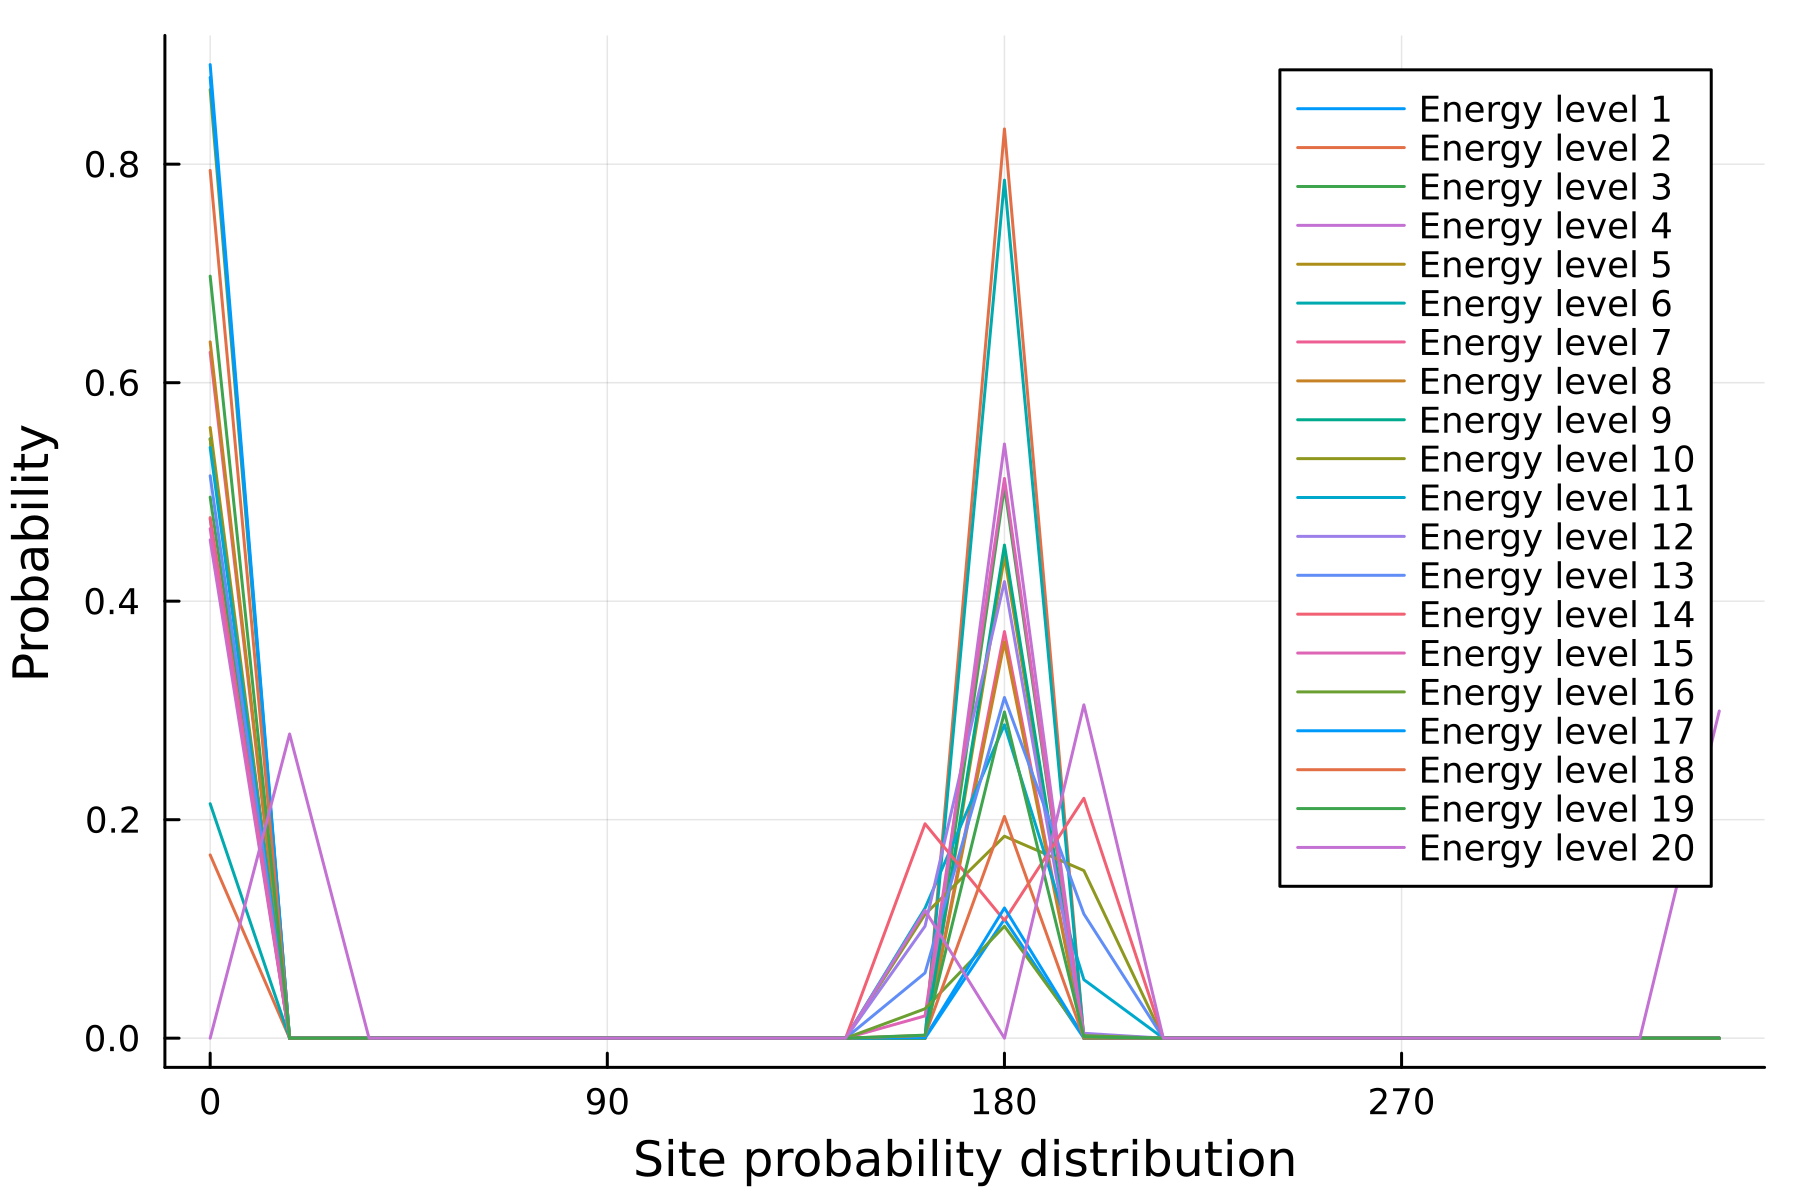

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\dmrg\\ed\\2024_05_30_single_site2_4_probability_DVR_dist_g=inf.png"

In [116]:
using Plots

# data = hist_data[:,:,1]
p = plot(ylabel="Probability", xlabel="Site probability distribution",dpi=300, xticks=([0,90,180,270,360]))
for (i,energy_level) in enumerate(1:20)
    data = hist_data[:,2,energy_level]
    # bar!(p,float(0:length(data)-1) ./length(data) .* 360, reshape(data, length(data)), #alpha=0.6, 
    # label=string("Energy level ", energy_level), bar_width = 360/length(data))
    plot!(p,float(0:length(data)-1) ./length(data) .* 360, reshape(data, length(data)), #alpha=0.6, 
        label=string("Energy level ", energy_level))
end
display(p)
savefig("2024_05_30_single_site2_4_probability_DVR_dist_g=inf.png")

In [37]:
mmax = 8
Nsites = 4
angle = 0
Estrength = 0
g = 1.1
pairs = "nearest"
energies = 20

initial_state = rand(ComplexF64, (2*mmax+1)^Nsites)
H(x) = Hamiltonian(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs)
memory = @allocated(tmp = KrylovKit.eigsolve(H, initial_state, energies, :SR))
vals, vecs, info = tmp

vals

20-element Vector{ComplexF64}:
  -2.199872893652409 + 4.65410489323531e-16im
 -2.1997288904038093 - 8.684210859019297e-16im
 -2.1996248850432676 + 3.1891922384448466e-18im
 -2.1995720789926274 - 3.858478454386299e-16im
  -2.199283109769223 + 5.424344092179119e-16im
  -2.199221854509176 + 1.5358437633019782e-16im
  -2.199135747007101 + 7.36884316048572e-16im
 -2.1986398339182514 + 1.436832169640175e-15im
  -2.198518827647443 - 1.619315965239705e-16im
  -2.198199953006457 + 1.0403627848533516e-15im
  -2.197931842723508 - 1.1517106211616066e-16im
 -2.1971790217685645 + 1.22664635499186e-15im
 -2.1968628566912627 + 5.333728180136262e-16im
 -2.1965737284235356 + 2.2305906875043195e-15im
  -2.196163335186805 + 8.306205452016365e-16im
   -2.19511991027249 + 1.5938525654853054e-15im
  -2.194427813726046 + 4.502401952354512e-16im
 -2.1936545920557657 - 7.034699317850264e-16im
  -2.175643556465862 + 8.362796725523211e-17im
 -2.0152117619264116 + 3.0992306646056114e-18im

In [102]:
energy_level = 1
indices = sortperm(abs.(vecs[energy_level]))
p = (abs.(vecs[energy_level]).^2)[indices]
for i=0:20
    data = fill(-mmax, Nsites)
    inserted_data = digits(indices[end - i]-1, base=2*mmax+1)
    data[end-length(inserted_data)+1:end] += inserted_data
    println(data, " ", p[end-i])
end


[0, 0, 0, 0, 0, 0] 0.012139938475314548
[0, 0, -1, -1, 0, 0] 0.004977718167652199
[0, 0, 1, 1, 0, 0] 0.004977718167652062
[0, 0, 0, -1, -1, 0] 0.00489878699442347
[0, 1, 1, 0, 0, 0] 0.004898786994423406
[0, -1, -1, 0, 0, 0] 0.004898786994423351
[0, 0, 0, 1, 1, 0] 0.0048987869944233185
[0, 0, 0, 0, 1, 1] 0.004294423196721908
[1, 1, 0, 0, 0, 0] 0.004294423196721728
[-1, -1, 0, 0, 0, 0] 0.004294423196721655
[0, 0, 0, 0, -1, -1] 0.004294423196721494
[0, 1, 0, -1, 0, 0] 0.004254109627214301
[0, 0, 1, 0, -1, 0] 0.004254109627214234
[0, 0, -1, 0, 1, 0] 0.004254109627214213
[0, -1, 0, 1, 0, 0] 0.004254109627214123
[0, 1, 0, 0, 1, 0] 0.0040100169585847245
[0, -1, 0, 0, -1, 0] 0.004010016958584663
[0, 0, -1, 0, -1, 0] 0.003945868587240134
[0, -1, 0, -1, 0, 0] 0.003945868587240091
[0, 1, 0, 1, 0, 0] 0.0039458685872400786
[0, 0, 1, 0, 1, 0] 0.003945868587240045


In [39]:
hist_data = zeros(Int(2*mmax+1), Nsites, energies)
for energy_level=1:energies
    indices = sortperm(abs.(vecs[energy_level]))
    p = (abs.(vecs[energy_level]).^2)[indices]

    for i in 0:length(indices)-1
        data = fill(1, Nsites)
        inserted_data = digits(indices[end - i]-1, base=Int(2*mmax+1))
        data[end-length(inserted_data)+1:end] += inserted_data
        for (k, d) in enumerate(data)
            hist_data[d,k, energy_level] += p[end - i]
        end
        # println(hist_data)
    end
end
# bitstring(UInt16()

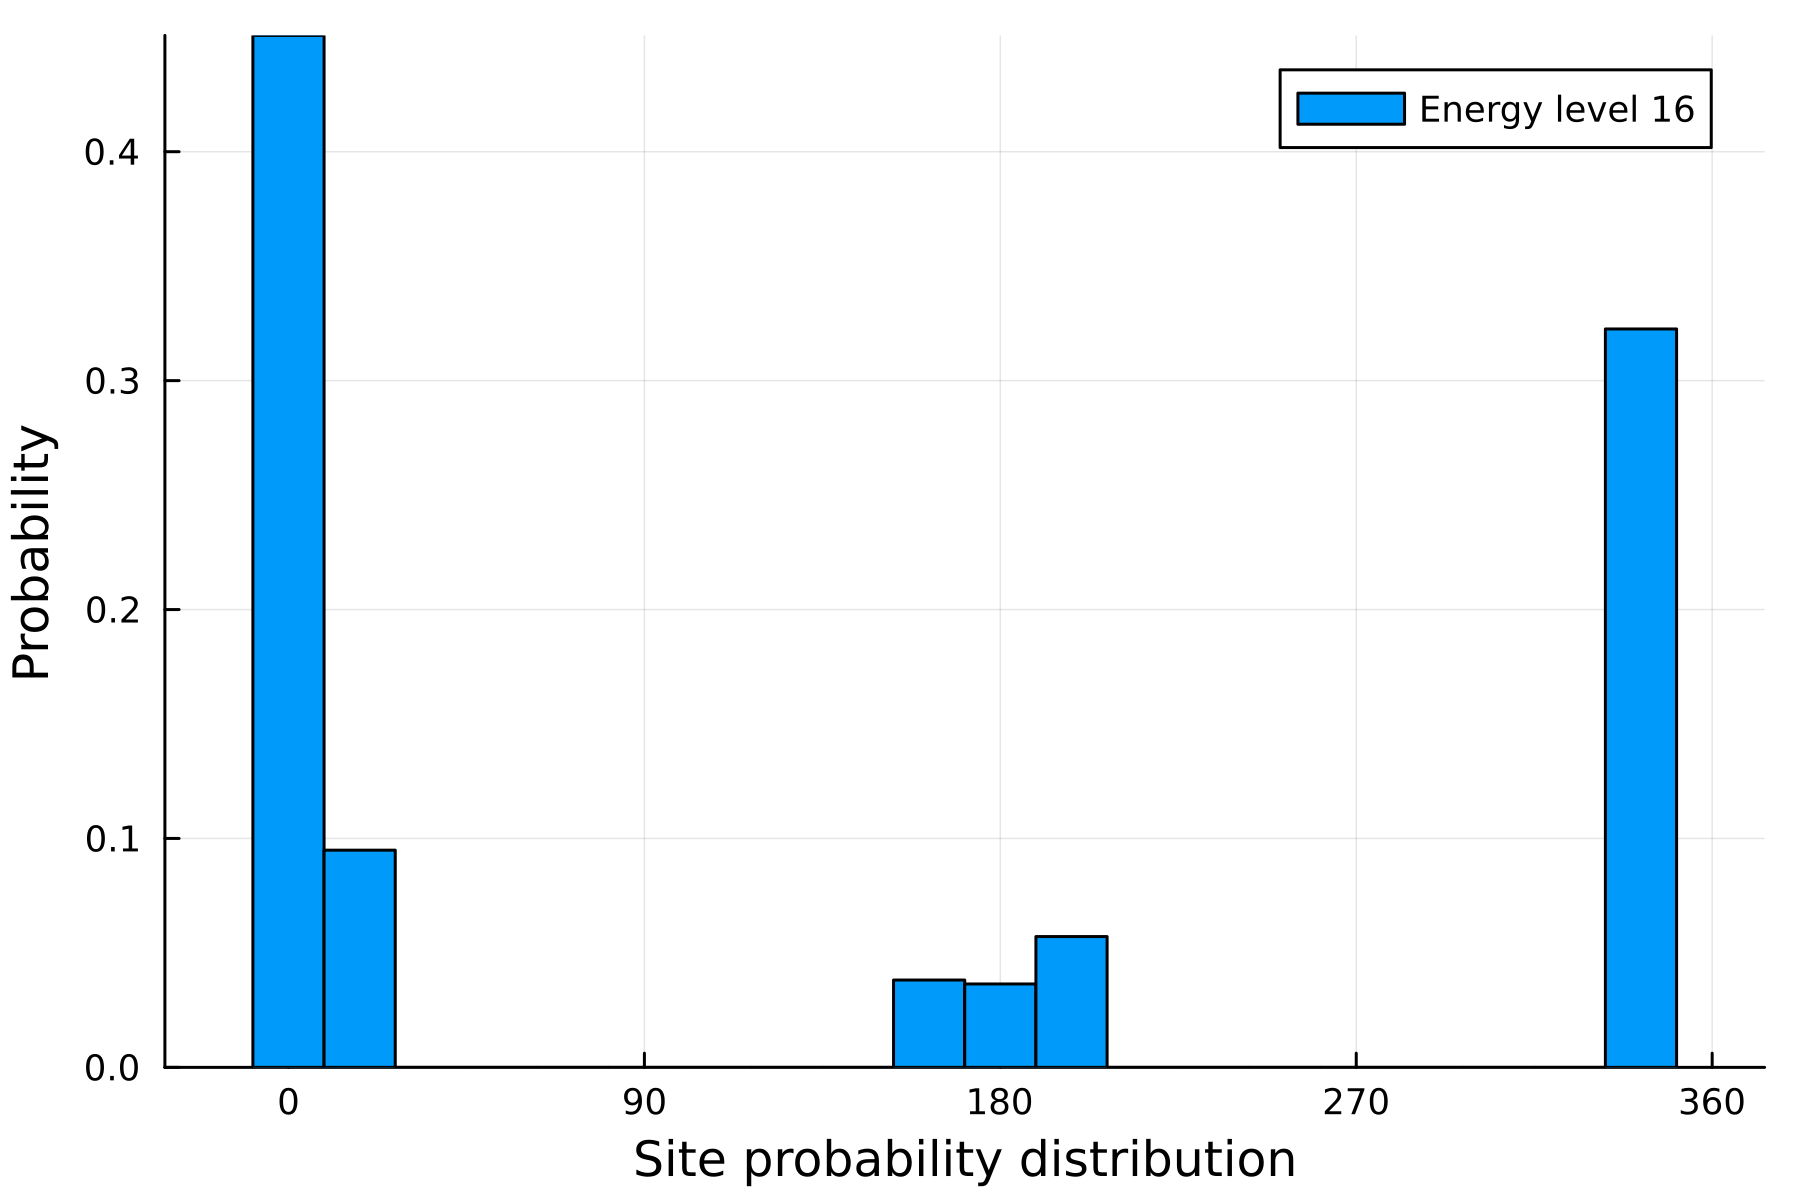

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\dmrg\\ed\\2024_05_30_single_site_probability_DVR_dist_g=inf.png"

In [82]:
using Plots

data = hist_data[:,:,1]
p = plot(ylabel="Probability", xlabel="Site probability distribution",
xticks=(1:length(data),[(i-mmax-1)%(2*mmax+1)==0 ? (i ÷ (2*mmax+1))+1 : "" for i=1:length(data)]),dpi=300)
for (i,energy_level) in enumerate([1,5,20])
    data = hist_data[:,:,energy_level]
    bar!(p,float(1:length(data)) .+ (i-2)/4, reshape(data, length(data)), #alpha=0.6, 
    label=string("Energy level ", energy_level), bar_width = 0.2, linecolor=nothing)
end
# display(p)
savefig("2024_05_29_single_site_probability_dist_g=100.png")